In [2]:
from nba_api.stats.endpoints import LeagueDashPlayerStats
import time
from unidecode import unidecode
import pandas as pd
import os

# Set your home directory explicitly
home_dir = "/Users/neeldavuluri"
output_path = os.path.join(home_dir, "player_stats.csv")

print("Saving to:", output_path)

# --- Base per-game stats ---
stats_base = LeagueDashPlayerStats(
    season='2024-25',
    per_mode_detailed='PerGame'
).get_data_frames()[0]
time.sleep(1)

# --- Advanced per-game stats ---
stats_adv = LeagueDashPlayerStats(
    season='2024-25',
    per_mode_detailed='PerGame',
    measure_type_detailed_defense='Advanced'
).get_data_frames()[0]
time.sleep(1)

# Clean names
stats_base['PLAYER_NAME'] = stats_base['PLAYER_NAME'].apply(unidecode)
stats_adv['PLAYER_NAME'] = stats_adv['PLAYER_NAME'].apply(unidecode)

# Merge
nba_df = stats_base.merge(
    stats_adv,
    on='PLAYER_ID',
    suffixes=('_base', '_adv')
)

# Drop duplicate name column
if 'PLAYER_NAME_adv' in nba_df.columns:
    nba_df.drop(columns=['PLAYER_NAME_adv'], inplace=True)
    nba_df.rename(columns={'PLAYER_NAME_base': 'PLAYER_NAME'}, inplace=True)

# Save to your Mac home directory
nba_df.to_csv(output_path, index=False)

print(f"Saved data to: {output_path}")

Saving to: /Users/neeldavuluri/player_stats.csv
Saved data to: /Users/neeldavuluri/player_stats.csv


In [3]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os

def spider(url):
    useragent = f'ds6021rt/0.0 (yht7nf@virginia.edu) python-requests/{requests.__version__}'
    headers = {'User-Agent': useragent, 'From': 'yht7nf@virginia.edu'}

    r = requests.get(url, headers=headers)
    mysoup = BeautifulSoup(r.text, 'html.parser')

    # Extract player names
    player_list = mysoup.select('td:has(a)')
    player_list = player_list[::2]     # ESPN double-lists players
    players = [td.find("a").get_text(strip=True) for td in player_list]

    # Extract salaries
    salaries = mysoup.select('td[style*="text-align:right"]:not([width])')
    salaries = [td.get_text(strip=True) for td in salaries]

    # Combine
    df = pd.DataFrame({
        "PLAYER_NAME": players,
        "SALARY": salaries
    })
    return df


if __name__ == "__main__":
    new_df = pd.DataFrame()

    for i in range(1, 14):
        url = f"https://www.espn.com/nba/salaries/_/year/2025/page/{i}"
        df = spider(url)
        new_df = pd.concat([new_df, df], ignore_index=True)

    # 🔥 Save directly to your home directory
    output_path = "/Users/neeldavuluri/24-25_salaries.csv"
    new_df.to_csv(output_path, index=False)

    print(f"Saved to: {output_path}")

Saved to: /Users/neeldavuluri/24-25_salaries.csv


In [4]:
import pandas as pd
import numpy as np

# Load Data
nba = pd.read_csv('/Users/neeldavuluri/player_stats.csv')
salaries = pd.read_csv('/Users/neeldavuluri/24-25_salaries.csv')

nba['helper'] = nba['PLAYER_NAME'].str.lower()\
    .str.replace('.', '', regex=False)\
        .str.replace("'", '', regex=False)\
            .str.replace(' ', '', regex=False)
            
salaries['helper'] = salaries['PLAYER_NAME'].str.lower()\
    .str.replace('.', '', regex=False)\
        .str.replace("'", '', regex=False)\
            .str.replace(' ', '', regex=False)

merged = pd.merge(
    nba, 
    salaries[['helper', 'SALARY']],
    on='helper',
    how='outer', 
    validate='one_to_one', 
    indicator=True
)

merged = merged[merged['_merge'] == 'both']
merged = merged.drop(columns=['helper', '_merge'])

merged['SALARY'] = merged['SALARY']\
    .astype(str).str.replace('$', '', regex=False)\
        .str.replace(',', '', regex=False)
merged['SALARY'] = pd.to_numeric(merged['SALARY'], errors='coerce')

merged.to_csv('/Users/neeldavuluri/nba_data_with_salaries.csv', index=False)

In [5]:
merged.columns

Index(['PLAYER_ID', 'PLAYER_NAME', 'NICKNAME_base', 'TEAM_ID_base',
       'TEAM_ABBREVIATION_base', 'AGE_base', 'GP_base', 'W_base', 'L_base',
       'W_PCT_base',
       ...
       'PACE_RANK', 'sp_work_PACE_RANK', 'PIE_RANK', 'FGM_RANK_adv',
       'FGA_RANK_adv', 'FGM_PG_RANK', 'FGA_PG_RANK', 'FG_PCT_RANK_adv',
       'TEAM_COUNT_adv', 'SALARY'],
      dtype='object', length=145)

numeric columns only for the features, select good PCA features

In [ ]:
df = merged.copy()

#numeric-only
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

#remove salary and IDs from PCA 
exclude = [
    "PLAYER_ID",
    "TEAM_ID_base",
    "TEAM_ID_adv" if "TEAM_ID_adv" in df.columns else None,
    "SALARY"
]
exclude = [x for x in exclude if x is not None]

#remove rank columns
rank_cols = [c for c in numeric_cols if "RANK" in c]

pca_features = [c for c in numeric_cols if c not in exclude and c not in rank_cols]

print(len(pca_features), "features selected for PCA")
pca_features[:20]

71 features selected for PCA


['AGE_base',
 'GP_base',
 'W_base',
 'L_base',
 'W_PCT_base',
 'MIN_base',
 'FGM_base',
 'FGA_base',
 'FG_PCT_base',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV']

min 10mpg requirement

In [ ]:
df_model = df[df["MIN_base"] >= 10].copy()

#drop missing values
df_model = df_model.dropna(subset=pca_features)


scale data

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[pca_features])


fit PCA (with all components first)

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None, random_state=0)
X_pca = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_

explaining the variance

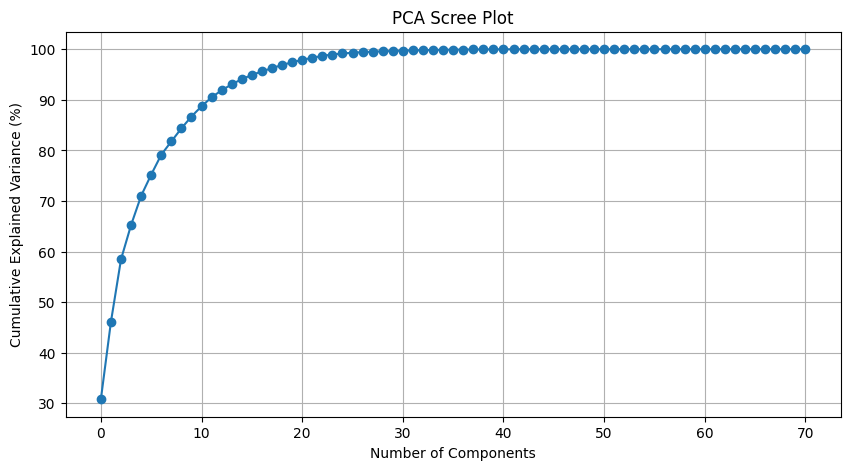

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(np.cumsum(explained)*100, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.show()

92% of variance explained by 12 components, 30% with PC1, 80% with PC6

loading matrix

In [15]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=pca_features,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

loadings_top6 = loadings.iloc[:, :6]
loadings_top6

,PC1,PC2,PC3,PC4,PC5,PC6
AGE_base,0.017993,0.049628,-0.033194,-0.004875,-0.188340,0.189987
GP_base,0.090671,0.075839,-0.049645,0.328746,0.106641,0.100894
W_base,0.095655,0.210834,-0.076397,0.142428,0.055118,0.042064
L_base,0.025652,-0.133710,0.014447,0.335420,0.098230,0.104896
W_PCT_base,0.056184,0.251853,-0.069032,-0.072348,-0.006948,-0.016856
...,...,...,...,...,...,...
FGA_adv,0.193009,-0.031095,-0.061987,0.105821,0.031695,-0.004633
FGM_PG,0.203411,-0.059363,0.009296,-0.031018,-0.012043,-0.066751
FGA_PG,0.196326,-0.089657,-0.046790,-0.046129,-0.019160,-0.078861
FG_PCT_adv,0.040459,0.110639,0.244640,0.091444,0.026593,0.046161


In [20]:
for i in range(6):
    print(f"\nTop features for PC{i+1}:")
    print(loadings_top6.iloc[:, i].sort_values(ascending=False).head(10))
    print(loadings_top6.iloc[:, i].sort_values().head(10))


Top features for PC1:
WNBA_FANTASY_PTS    0.207278
NBA_FANTASY_PTS     0.205392
FGM_PG              0.203411
FGM_base            0.203411
PTS                 0.203102
FGM_adv             0.197291
FGA_PG              0.196326
FGA_base            0.196326
FGA_adv             0.193009
MIN_adv             0.187577
Name: PC1, dtype: float64
TEAM_COUNT_adv    -0.031984
TEAM_COUNT_base   -0.031984
OREB_PCT          -0.024979
E_TOV_PCT         -0.023753
TM_TOV_PCT        -0.022520
PACE_PER40        -0.017194
PACE              -0.017185
sp_work_PACE      -0.017185
E_DEF_RATING       0.000049
AST_RATIO          0.016060
Name: PC1, dtype: float64

Top features for PC2:
E_NET_RATING          0.263360
NET_RATING            0.260828
sp_work_NET_RATING    0.260828
PLUS_MINUS            0.254022
W_PCT_base            0.251853
W_PCT_adv             0.251853
W_base                0.210834
W_adv                 0.210834
E_OFF_RATING          0.196465
OFF_RATING            0.184696
Name: PC2, dtype: floa